In [1]:
import numpy as np
import pandas as pd
import random
import numpy.random as nr
from sklearn import datasets
import matplotlib.pyplot as plt

Question 3

In [2]:
def estimator(X, y, B=1000, random_matrix_generator=None, min_k=1, max_k=100, sampling_distribution=None):
    """
    Performs randomized estimations to compute an averaged Beta matrix over a specified number of iterations.
    X: Matrix of predictor variables (X)
    y: Vector of response variables (y)
    B: Number of iterations for averaging Beta estimates
    random_matrix_generator: Function to generate random matrices, defaults to a coin flip simulation
    min_k: Minimum value for sampling k in random matrix generation
    max_k: Maximum value for sampling k in random matrix generation
    sampling_distribution: Probability distribution function for sampling k, defaults to uniform distribution
    return: Averaged Beta matrix over specified iterations
    """
    num_samples = len(y)
    num_features = X.shape[1]

    if random_matrix_generator is None:
        random_matrix_generator = lambda k, n: np.random.choice([-1, 1], size=(k, n))

    sigma_matrix = np.zeros((num_features, num_features)) # Initialize Sigma matrix
    gamma_vector = np.zeros((num_features, 1)) # Initialize Gamma matrix
    beta_matrix = np.zeros((num_features, 1)) # Initialize Beta matrix

    # Compute sigma and gamma matrices
    for i in range(num_samples):
        data_vector = np.array(X.iloc[i, :]).reshape(-1, 1)
        target_value = y[i]
        sigma_matrix += data_vector @ data_vector.T
        gamma_vector += data_vector * target_value

    sigma_matrix /= num_samples # Normalize Sigma
    gamma_vector /= num_samples # Normalize Gamma

    # Perform iterations to estimate Beta
    for _ in range(B):
        k = sampling_distribution(min_k, max_k) if sampling_distribution else random.randint(min_k, max_k)
        random_matrix = random_matrix_generator(k, num_features)
        intermediate_matrix = random_matrix @ sigma_matrix @ random_matrix.T
        projected_beta = np.linalg.inv(intermediate_matrix) @ random_matrix @ gamma_vector
        beta_matrix += random_matrix.T @ projected_beta

    averaged_beta = beta_matrix / B # Calculate average Beta over B iterations
    return averaged_beta


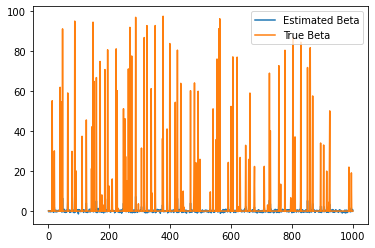

In [3]:
nr.seed(1)
X, y, t_coef = datasets.make_regression(n_samples=10000,n_features=1000,n_informative=100,coef=True)
X = pd.DataFrame(X)
Beta_ave = estimator(X, y, min_k=50, max_k=100)
plt.plot(range(1,X.shape[1]+1),Beta_ave, label = "Estimated Beta")
plt.plot(range(1,X.shape[1]+1), t_coef, label = "True Beta")
plt.legend()
plt.show()

Question 4

In [4]:
np.random.seed(0)
n = 100
p = 30
k = 5
X_full = np.random.uniform(low = 0, high = 1, size = n * p).reshape(n, p)
beta_true = np.random.normal(0, 1, p).reshape(p, 1)
y_full = X_full @ beta_true + np.random.normal(size = n).reshape(n, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.2, random_state = 42)

In [5]:
def f_n(X, Omega):
    n = X.shape[0] 
    p = X.shape[1]
    k = Omega.shape[0]
    
    sum_of_squares = 0
    
    for i in range(n):
        for j in range(n):
            original_inner_product = X[i, :].dot(X[j, :])
            projected_inner_product = (Omega.dot(X[i, :])).dot(Omega.dot(X[j, :]))
            sum_of_squares += (original_inner_product - projected_inner_product) ** 2
            
    return sum_of_squares


In [6]:
Omega_norm = np.random.normal(0, 1, k*p).reshape(k, p)

In [7]:
Omegas = [2 * np.random.binomial(n = 1, p = 0.5, size = k * p).reshape(k, p) - 1 for i in range(30)]
Omega_n = Omegas[np.argmin([f_n(X_train, Omega) for Omega in Omegas])]

In [8]:
def compute_mse(X_train, y_train, X_test, y_test, Omega):
    X_train_proj = X_train @ Omega.T
    X_test_proj = X_test @ Omega.T
    beta_proj = np.linalg.inv(X_train_proj.T @ X_train_proj) @ X_train_proj.T @ y_train
    y_pred = X_test_proj @ beta_proj
    mse = ((y_test - y_pred) ** 2).mean()
    return mse

mse_norm = compute_mse(X_train, y_train, X_test, y_test, Omega_norm)
mse_kdim = compute_mse(X_train, y_train, X_test, y_test, Omega_n)

print(f'f_n for normal projection: {f_n(X_train, Omega_norm)}')
print(f'f_n for k-dim embedding: {f_n(X_train, Omega_n)}')

print(f'MSE for normal projection: {mse_norm}')
print(f'MSE for k-dim embedding: {mse_kdim}')


f_n for normal projection: 11302719.100843692
f_n for k-dim embedding: 523019.73283881106
MSE for normal projection: 3.06229659576566
MSE for k-dim embedding: 1.9999558068810184
